참고한 코드 : https://dacon.io/codeshare/4231
( minist 불러오기 및, keras로 generator와 discriminator 정의 하기 )

참고한 이론적 배경 : https://youtu.be/AVvlDmhHgC4?si=tEyV-KBbGdNrZ_yo


In [27]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.callbacks import Callback
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# MNIST 데이터 셋 가져오기

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [9]:
x_train.shape

(60000, 28, 28)

In [10]:
x_test.shape

(10000, 28, 28)

In [11]:
x_train.min(), x_train.max()

(0, 255)

generator에서 tanh를 activation으로 활용할 것입니다.

tanh를 활용하면 output이 -1 ~ 1 사이로 나오기 때문에

Normalize를 해줄 때 127.5로 나눈 뒤 1을 빼주어

범위를 -1~1 사이로 만들어 줍시다.

In [12]:
x_train = x_train / 127.5 - 1
x_test = x_test / 127.5 - 1

In [13]:
x_train.min(), x_train.max()

(-1.0, 1.0)

flatting

In [14]:
x_train = x_train.reshape(-1, 784)
x_train.shape

(60000, 784)

# HyperParameter 세팅

In [50]:
NOISE_DIM = 100
BATCH_SIZE = 256
EPOCHS = 50

# Generator 정의

In [63]:
generator = Sequential([
    Dense(256, input_dim=NOISE_DIM),
    LeakyReLU(0.2),
    Dense(512),
    LeakyReLU(0.2),
    Dense(1024),
    LeakyReLU(0.2),
    Dense(28*28, activation='tanh'),
])

In [64]:
generator.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 256)                 │          25,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_14 (LeakyReLU)           │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 784)                 │         803,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,486,352 (5.67 MB)

 Trainable params: 1,486,352 (5.67 MB)

 Non-trainable params: 0 (0.00 B)

# Discriminator 판별자 정의

In [65]:
discriminator = Sequential([
    Dense(1024, input_shape=(784,), kernel_initializer=RandomNormal(stddev=0.02)),
    LeakyReLU(0.2),
    Dropout(0.3),
    Dense(512),
    LeakyReLU(0.2),
    Dropout(0.3),
    Dense(256),
    LeakyReLU(0.2),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [66]:
discriminator.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                     │ (None, 1024)                │         803,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_16 (LeakyReLU)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_17 (LeakyReLU)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,460,225 (5.57 MB)

 Trainable params: 1,460,225 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

#GAN 구성

In [67]:
# Custom GAN 모델 클래스 정의
class GAN(Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.uniform([batch_size, NOISE_DIM], minval=-1, maxval=1)

        # 1. Train Discriminator
        with tf.GradientTape() as tape:
            # 가짜 이미지 생성
            generated_images = self.generator(noise, training=True)

            # 판별기 예측
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # 손실 계산
            d_loss_real = self.loss_fn(tf.ones_like(real_output), real_output)
            d_loss_fake = self.loss_fn(tf.zeros_like(fake_output), fake_output)
            d_loss = d_loss_real + d_loss_fake

        # 기울기 계산 및 적용
        d_gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

        # 2. Train Generator
        noise = tf.random.uniform([batch_size, NOISE_DIM], minval=-1, maxval=1)
        with tf.GradientTape() as tape:
            generated_images = self.generator(noise, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            g_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)

        # 기울기 계산 및 적용
        g_gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}


### 손실 계산의 배경

1. **판별기(Discriminator)의 목적**: 판별기의 목표는 진짜 이미지를 가짜 이미지와 구별하는 것입니다. 진짜 이미지를 진짜라고 예측하고, 가짜 이미지를 가짜라고 예측해야 합니다.
   
2. **생성기(Generator)의 목적**: 생성기의 목표는 판별기를 속여서 가짜 이미지를 진짜 이미지처럼 보이게 만드는 것입니다. 즉, 생성된 가짜 이미지가 판별기에 의해 진짜 이미지로 분류되기를 원합니다.

### 코드 분석

```python
# 가짜 이미지 생성
generated_images = self.generator(noise, training=True)

# 판별기 예측
real_output = self.discriminator(real_images, training=True)
fake_output = self.discriminator(generated_images, training=True)

# 손실 계산
d_loss_real = self.loss_fn(tf.ones_like(real_output), real_output)
d_loss_fake = self.loss_fn(tf.zeros_like(fake_output), fake_output)
d_loss = d_loss_real + d_loss_fake
```

#### 1. 가짜 이미지 생성

- **`generated_images = self.generator(noise, training=True)`**: 랜덤한 노이즈를 입력으로 받아 생성기가 가짜 이미지를 생성합니다.

#### 2. 판별기 예측

- **`real_output = self.discriminator(real_images, training=True)`**: 판별기가 진짜 이미지를 입력받아 그것이 진짜일 확률을 출력합니다.
- **`fake_output = self.discriminator(generated_images, training=True)`**: 판별기가 생성된 가짜 이미지를 입력받아 그것이 진짜일 확률을 출력합니다.

#### 3. 손실 계산

- **진짜 이미지에 대한 손실 (`d_loss_real`)**:
  - **`d_loss_real = self.loss_fn(tf.ones_like(real_output), real_output)`**:
    - 진짜 이미지를 진짜로 예측할 때의 손실을 계산합니다.
    - `tf.ones_like(real_output)`은 진짜 이미지에 대해 `1` (즉, 진짜임을 의미)을 기대하며, `real_output`은 판별기의 예측 확률입니다.
    - `self.loss_fn`은 일반적으로 `binary_crossentropy` 손실을 사용하며, 판별기가 진짜 이미지를 얼마나 잘 예측했는지를 평가합니다.
  
- **가짜 이미지에 대한 손실 (`d_loss_fake`)**:
  - **`d_loss_fake = self.loss_fn(tf.zeros_like(fake_output), fake_output)`**:
    - 가짜 이미지를 가짜로 예측할 때의 손실을 계산합니다.
    - `tf.zeros_like(fake_output)`은 가짜 이미지에 대해 `0` (즉, 가짜임을 의미)을 기대하며, `fake_output`은 판별기의 예측 확률입니다.
    - 이 손실은 판별기가 가짜 이미지를 얼마나 잘 구분했는지를 평가합니다.

- **판별기의 총 손실 (`d_loss`)**:
  - **`d_loss = d_loss_real + d_loss_fake`**:
    - 진짜와 가짜 이미지에 대한 손실을 모두 더하여 판별기의 전체 손실을 구합니다.
    - 판별기의 목표는 이 총 손실을 최소화하여 진짜와 가짜 이미지를 올바르게 분류하는 것입니다.

### 생성기 손실

생성기의 손실 계산은 다음과 같이 이뤄집니다:

- **생성기 손실 (`g_loss`)**:
  - **`g_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)`**:
    - 생성기는 가짜 이미지를 진짜로 예측하게 만들기 위해 `tf.ones_like(fake_output)`을 기대합니다.
    - 이는 생성기가 판별기를 속이는 데 성공할수록 손실이 줄어드는 형태입니다.



#Batch

In [58]:
def get_dataset(data, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
    return dataset

# 시각화를 위한 콜백 함수 정의

In [68]:
# 학습 시각화 콜백 정의
class GANMonitor(Callback):
    def __init__(self, num_samples=24, latent_dim=100, frequency=5):
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        self.frequency = frequency
        self.d_losses = []  # 판별기 손실 저장
        self.g_losses = []  # 생성기 손실 저장

    def on_epoch_end(self, epoch, logs=None):
        self.d_losses.append(logs['d_loss'])
        self.g_losses.append(logs['g_loss'])

        if (epoch + 1) % self.frequency == 0:
            self.visualize_training(epoch + 1)

    def visualize_training(self, epoch):
        # 오차에 대한 시각화
        plt.figure(figsize=(8, 4))
        plt.plot(self.d_losses, label='Discriminator Loss')
        plt.plot(self.g_losses, label='Generator Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch,
              np.mean(self.d_losses), np.mean(self.g_losses)))

        # 샘플 데이터 생성 후 시각화
        noise = np.random.normal(0, 1, size=(self.num_samples, self.latent_dim))
        generated_images = self.model.generator.predict(noise)
        generated_images = generated_images.reshape(-1, 28, 28)

        plt.figure(figsize=(8, 4))

        for i in range(generated_images.shape[0]):
            plt.subplot(4, 6, i+1)
            plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.show()


#학습

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - d_loss: 0.8209 - g_loss: 1.3233
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - d_loss: 0.6807 - g_loss: 2.2688
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - d_loss: 0.6894 - g_loss: 2.5211
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - d_loss: 0.6787 - g_loss: 2.4153
Epoch 5/50
228/235 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - d_loss: 0.6027 - g_loss: 2.6716

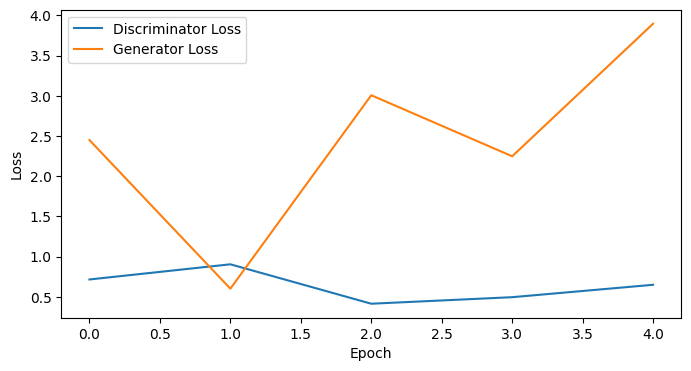

epoch: 5, Discriminator Loss: 0.6365933954715729, Generator Loss: 2.4412140607833863
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


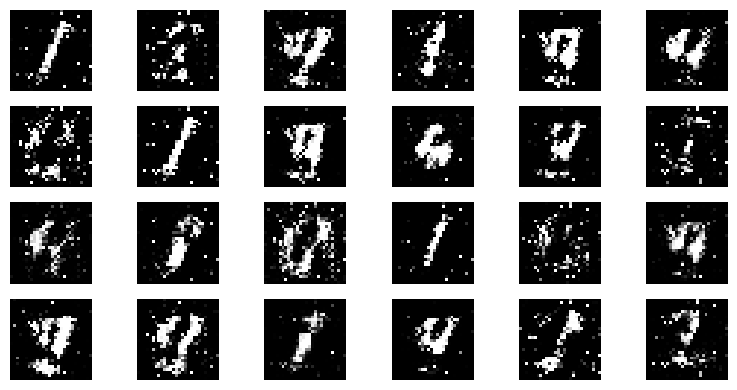

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - d_loss: 0.6017 - g_loss: 2.6779
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - d_loss: 0.5415 - g_loss: 2.8886
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - d_loss: 0.5504 - g_loss: 2.6692
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - d_loss: 0.4647 - g_loss: 2.7174
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - d_loss: 0.5825 - g_loss: 2.3633
Epoch 10/50
231/235 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - d_loss: 0.6621 - g_loss: 2.2134

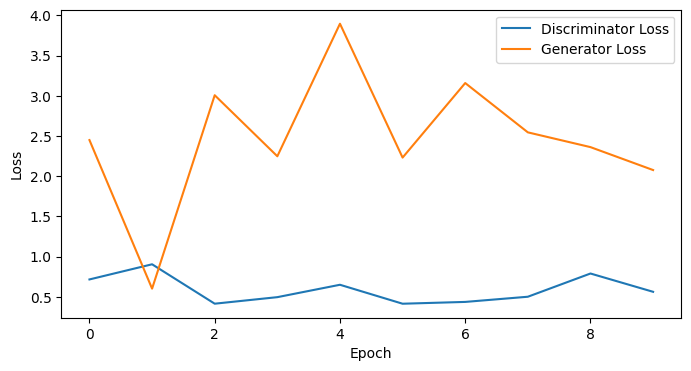

epoch: 10, Discriminator Loss: 0.5888935029506683, Generator Loss: 2.4583290219306946
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


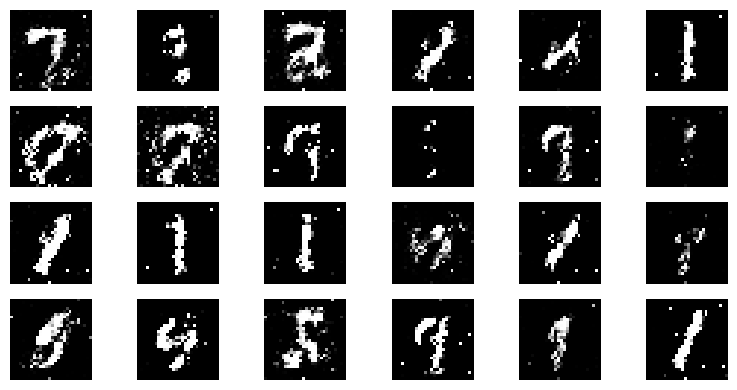

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - d_loss: 0.6605 - g_loss: 2.2118
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - d_loss: 0.6286 - g_loss: 2.2018
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - d_loss: 0.7023 - g_loss: 2.0444
Epoch 13/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - d_loss: 0.7148 - g_loss: 1.9825
Epoch 14/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - d_loss: 0.7495 - g_loss: 1.8648
Epoch 15/50
233/235 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - d_loss: 0.8173 - g_loss: 1.7260

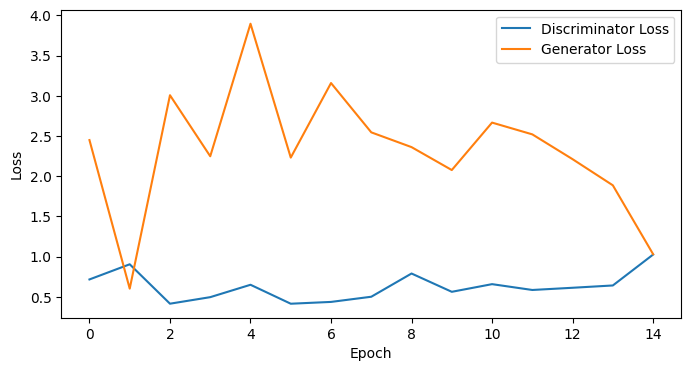

epoch: 15, Discriminator Loss: 0.6275127728780111, Generator Loss: 2.3268375317255656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


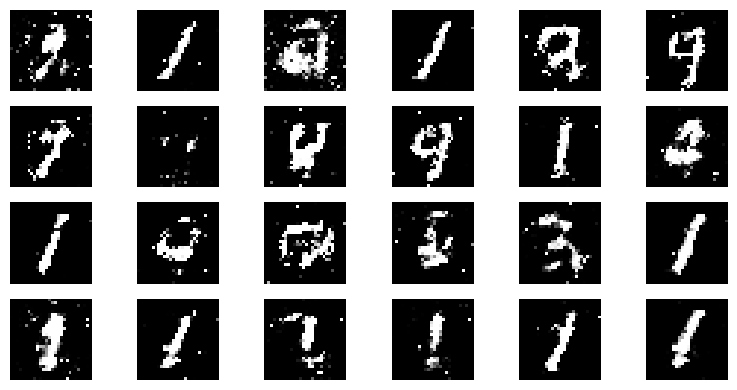

235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 111ms/step - d_loss: 0.8188 - g_loss: 1.7260
Epoch 16/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - d_loss: 0.8498 - g_loss: 1.6442
Epoch 17/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - d_loss: 0.8548 - g_loss: 1.6302
Epoch 18/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - d_loss: 0.8888 - g_loss: 1.5707
Epoch 19/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - d_loss: 0.9068 - g_loss: 1.5370
Epoch 20/50
231/235 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - d_loss: 0.9556 - g_loss: 1.4443

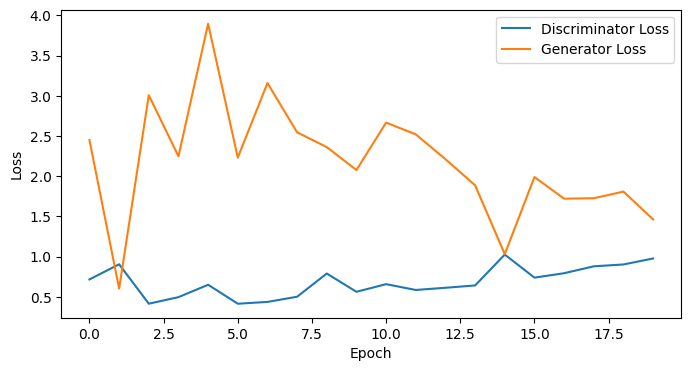

epoch: 20, Discriminator Loss: 0.685287743806839, Generator Loss: 2.180657458305359
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


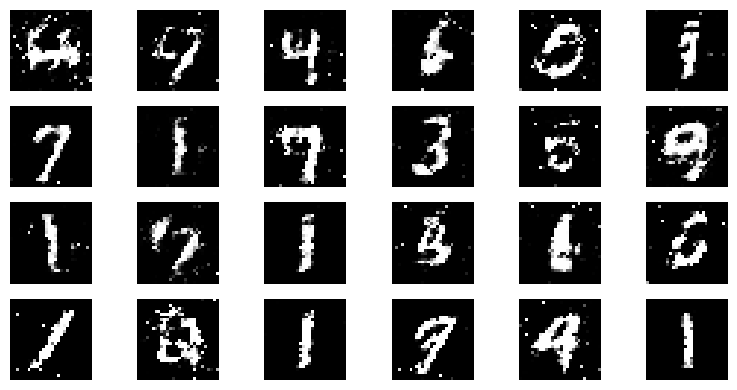

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - d_loss: 0.9549 - g_loss: 1.4457
Epoch 21/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - d_loss: 0.9435 - g_loss: 1.4534
Epoch 22/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - d_loss: 0.9683 - g_loss: 1.4168
Epoch 23/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - d_loss: 0.9867 - g_loss: 1.3937
Epoch 24/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - d_loss: 0.9966 - g_loss: 1.3799
Epoch 25/50
225/235 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - d_loss: 1.0215 - g_loss: 1.3279

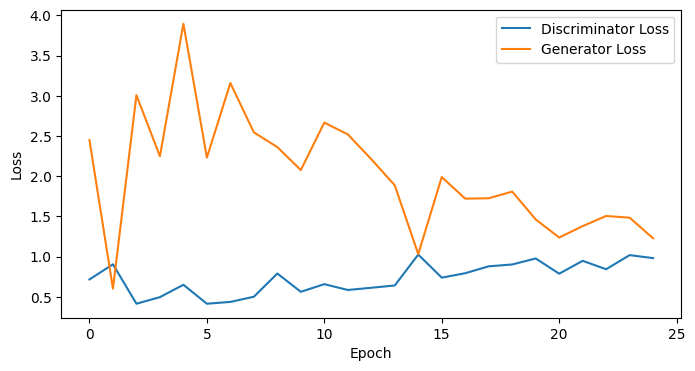

epoch: 25, Discriminator Loss: 0.7314567756652832, Generator Loss: 2.0179685449600218
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


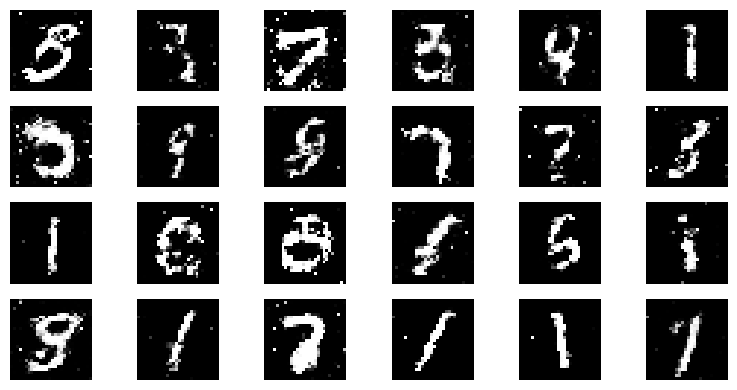

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - d_loss: 1.0228 - g_loss: 1.3277
Epoch 26/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - d_loss: 1.0328 - g_loss: 1.2967
Epoch 27/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - d_loss: 1.0351 - g_loss: 1.2971
Epoch 28/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - d_loss: 1.0473 - g_loss: 1.2748
Epoch 29/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - d_loss: 1.0579 - g_loss: 1.2602
Epoch 30/50
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - d_loss: 1.0633 - g_loss: 1.2438

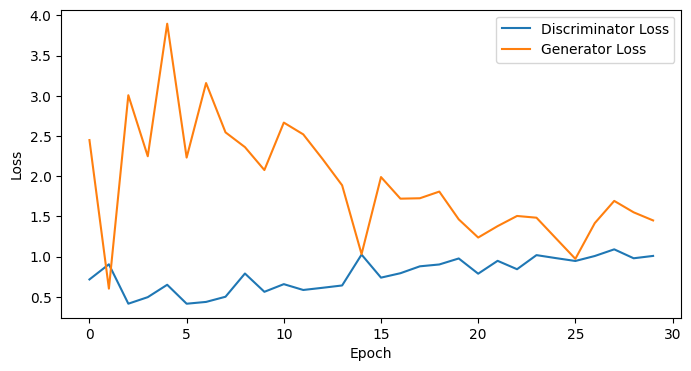

epoch: 30, Discriminator Loss: 0.7773518562316895, Generator Loss: 1.9178203841050465
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


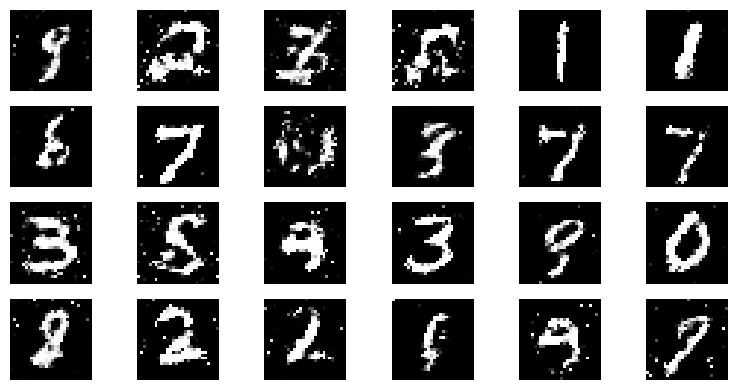

235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - d_loss: 1.0623 - g_loss: 1.2451
Epoch 31/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - d_loss: 1.0623 - g_loss: 1.2413
Epoch 32/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - d_loss: 1.0801 - g_loss: 1.2178
Epoch 33/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - d_loss: 1.0827 - g_loss: 1.2037
Epoch 34/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - d_loss: 1.0841 - g_loss: 1.2098
Epoch 35/50
228/235 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - d_loss: 1.0930 - g_loss: 1.1949

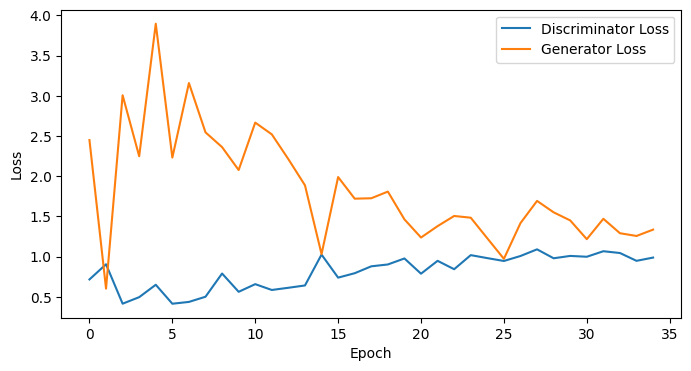

epoch: 35, Discriminator Loss: 0.8105324642998831, Generator Loss: 1.8316614304270062
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


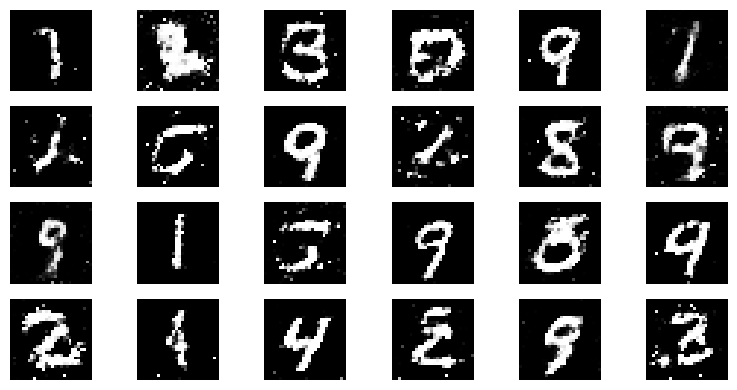

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - d_loss: 1.0920 - g_loss: 1.1954
Epoch 36/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - d_loss: 1.0966 - g_loss: 1.1915
Epoch 37/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - d_loss: 1.1041 - g_loss: 1.1847
Epoch 38/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - d_loss: 1.1112 - g_loss: 1.1610
Epoch 39/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - d_loss: 1.1145 - g_loss: 1.1589
Epoch 40/50
229/235 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - d_loss: 1.1247 - g_loss: 1.1363

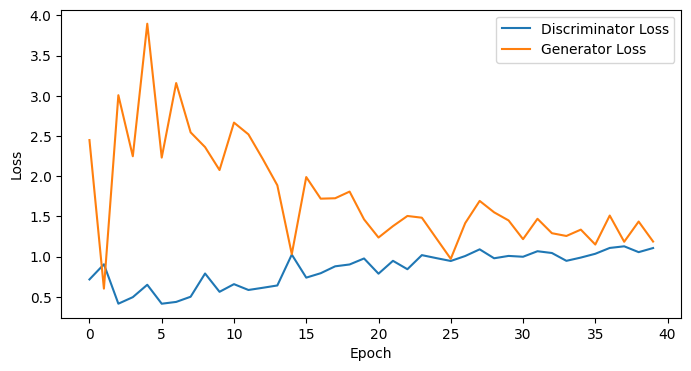

epoch: 40, Discriminator Loss: 0.8451183646917343, Generator Loss: 1.7644963696599008
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


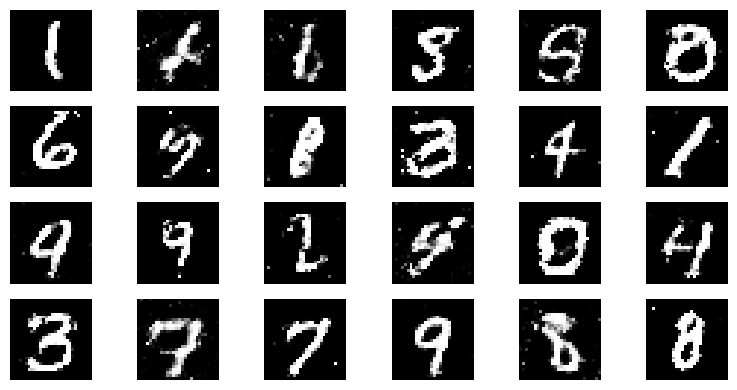

235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - d_loss: 1.1241 - g_loss: 1.1380
Epoch 41/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - d_loss: 1.1270 - g_loss: 1.1390
Epoch 42/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - d_loss: 1.1307 - g_loss: 1.1344
Epoch 43/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - d_loss: 1.1413 - g_loss: 1.1276
Epoch 44/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - d_loss: 1.1415 - g_loss: 1.1123
Epoch 45/50
233/235 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - d_loss: 1.1433 - g_loss: 1.1151

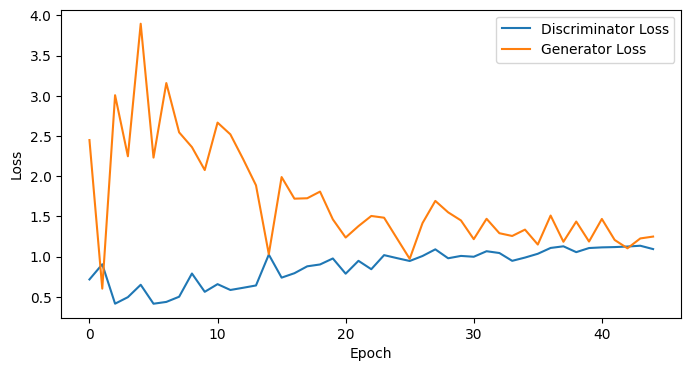

epoch: 45, Discriminator Loss: 0.875446187125312, Generator Loss: 1.70748444530699
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


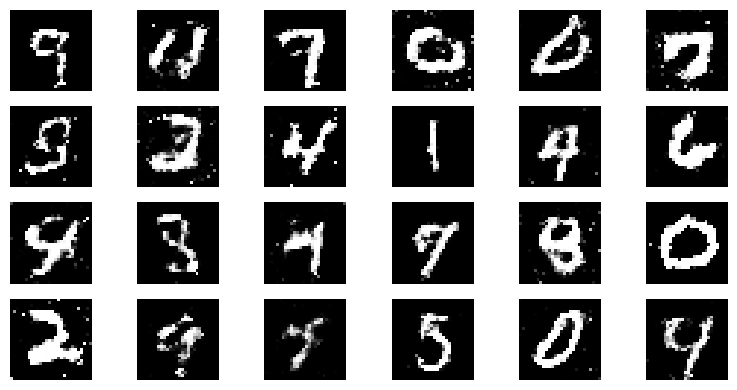

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - d_loss: 1.1430 - g_loss: 1.1159
Epoch 46/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - d_loss: 1.1506 - g_loss: 1.1111
Epoch 47/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - d_loss: 1.1524 - g_loss: 1.0978
Epoch 48/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - d_loss: 1.1609 - g_loss: 1.0962
Epoch 49/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - d_loss: 1.1610 - g_loss: 1.0853
Epoch 50/50
230/235 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - d_loss: 1.1637 - g_loss: 1.0830

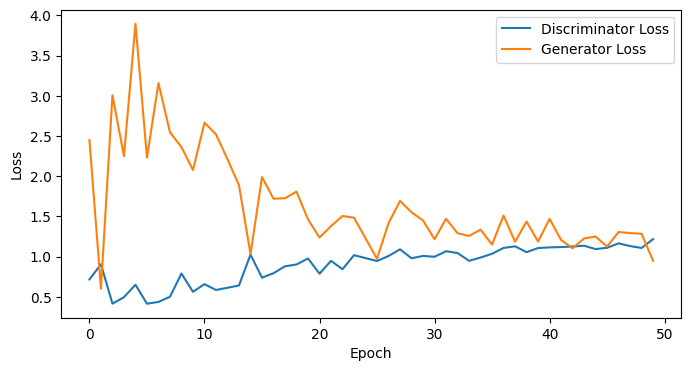

epoch: 50, Discriminator Loss: 0.9025723719596863, Generator Loss: 1.6558794033527375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


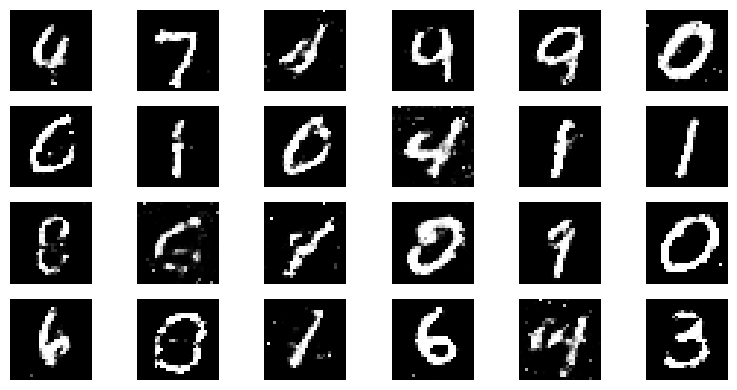

235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - d_loss: 1.1637 - g_loss: 1.0835


In [69]:
gan = GAN(generator=generator, discriminator=discriminator)

d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

gan.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

train_dataset = get_dataset(x_train, BATCH_SIZE)

# GAN 학습
gan.fit(train_dataset, epochs=EPOCHS, callbacks=[GANMonitor(latent_dim=NOISE_DIM)])